# Exploratory notebook
This is an exploratory notebook to understand how `OrderBike` works. It uses `UrbanToyGraph` to generate toy networks.

In [1]:
import networkx as nx
import numpy as np
import osmnx as ox
import shapely
from utg import create_graph
from utg import utils as utgut

from orderbike import growth
from orderbike import metrics
from orderbike import utils as ordut

## Directness
Let's see how directness works. Let's create a network, and take a pair of node as an origin and a destination

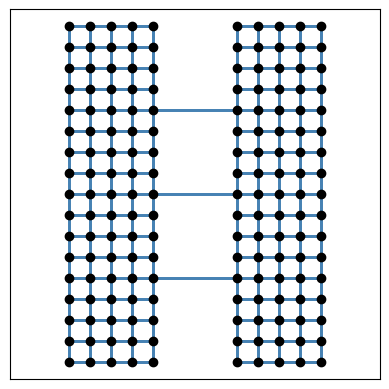

In [2]:
G = create_graph.create_bridge_graph(outrows=4, sscols=5, bridges=3, blength=200)
G = utgut.make_osmnx_compatible(G)
utgut.plot_graph(G)

In [3]:
orig = 0
dest = 85
print(G.nodes[orig], G.nodes[dest])

{'x': 0, 'y': 0} {'x': 400, 'y': 0}


Using `osmnx.routing.shortest_path` we can use weighted Dijkstra's algorithm to find the shortest network path between the two:

In [4]:
route = ox.routing.shortest_path(G, orig, dest, weight="length")
route

[0, 17, 34, 51, 68, 69, 70, 71, 72, 89, 88, 87, 86, 85]

We can then plot the route using `osmnx.plot_graph_route`:

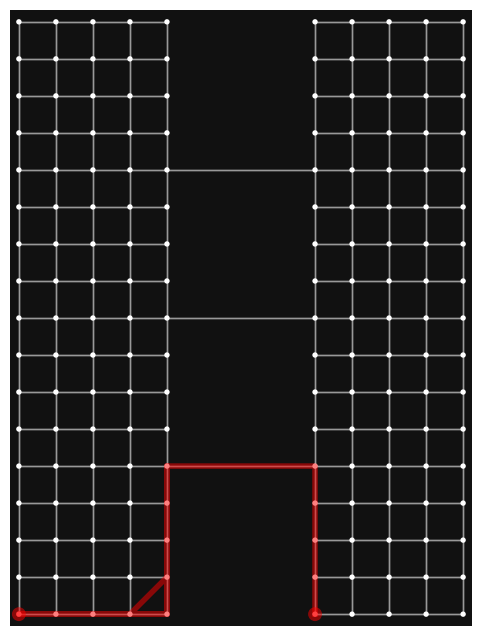

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph_route(G, route)

As we can see, the length of the route taken is twice as long as a straight route. The directness is the inverse, being the ratio of the euclidean distance on the shortest network path length.
To compute the directness, we first compute the shortest network path length:

In [6]:
sm = metrics.get_shortest_network_path_length_matrix(G)
sm[orig][dest]

800.0

Then, we compute the euclidean distance between the node:

In [7]:
em = metrics.get_euclidean_distance_matrix(G, lonlat=False)
em[orig][dest]

400.0

We then divide the euclidean distance by the shortest network path length. The value is 0 if the nodes are from different components, thus (i.e. no possible path between the two nodes). It gives us the directness of a path for an OD-pair, 1 being the shortest network path is also the shortest euclidean path, meaning a straight line :

In [8]:
dm = metrics.get_directness_matrix(G, lonlat=False)
dm[orig][dest]

0.5

By doing the mean of the directness of all non-zero values, we get the directness of the network:

In [9]:
np.sum(dm) / np.count_nonzero(dm)

0.7900126449020083

Let's take a basic square to compute the directness by hand:

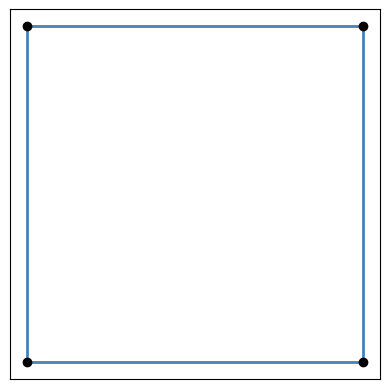

In [10]:
G = create_graph.create_grid_graph(cols=2, rows=2)
utgut.plot_graph(G)

In [11]:
metrics.get_directness(G, 0)

0.9023689270621825

For a square with 4 nodes on each vertex, there are 6 OD pairs, 4 of them are the sides, where the euclidean distance is the shortest network path length, meaning that their directness if 1, 2 of them are the diagonals, where the euclidean distance is $\sqrt{2}$ while the shortest network path is 2, meaning that their directness is $\sqrt{2}/2$. If we compute manually the network directness, we get the same result as above:

In [12]:
(4 * 1 + 2 * np.sqrt(2) / 2) / 6

0.9023689270621825

## Coverage
Coverage is defined as the area that is within reach of the bicycle network. The most naive way to compute it is to create a buffer on the unary union of all edges' geometries:

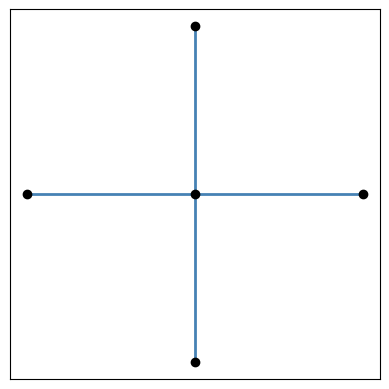

In [13]:
G = create_graph.create_radial_graph()
utgut.plot_graph(G)

The area for a small buffer of 2m is  809.0923879241404


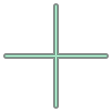

In [14]:
geom = [G.edges[edge]["geometry"] for edge in G.edges]
cov_small_buffer = shapely.unary_union(geom).buffer(2)
print("The area for a small buffer of 2m is ", cov_small_buffer.area)
cov_small_buffer

The area for a large buffer of 50m is  25682.742452723534


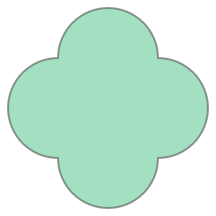

In [15]:
cov_large_buffer = shapely.unary_union(geom).buffer(50)
print("The area for a large buffer of 50m is ", cov_large_buffer.area)
cov_large_buffer

As we can see, when the buffer is larger (or the edges are closer to one another) the same zone is covered by multiple edges, meaning that edges individually do not have the same impact on coverage. To understand how much an edge add value to the coverage, we need to find the relative difference, where we normalize the coverage added by the length of the edge's length.

## MultiDiGraph to Graph

Based on the NetworkX definitions, a Graph has bidirectional edges, and there is at most one edge between two different nodes. A DiGraph has directional edges, so you have at most one edge between two different nodes, in a specific direction. A MultiGraph can have more than one edge between two nodes, and you can have a self-loop where an edge is connected on both ways to the same node. A MultiDiGraph is the combination of a DiGraph and a MultiGraph, so you can have any number of directional edges between any pair of nodes.

![](../plots/type_graph_networkx.png)

For Network Science, the Graph is the most studied one, where there is the highest number of metrics. For GIS, the MultiDiGraph is the best representation of a street network, as cars can only go in one direction, and you can have branching streets for the same pair of nodes, and self-loops where a street start and end at the same point.

OSMnx gets the street network from OSM as a MultiDiGraph. There are functions to transform this MultiDiGraph to a MultiGraph (removing directional edges), or to a DiGraph (removing parallel edges by minimizing the weight attribute and erasing self-loops). We created a function to transform it into a Graph while keeping all edges by adding artificial nodes 1 for parallel edges, 2 for self-loops.

![](../plots/multidigraph_to_graph.png)

The upside of this method is that while conserving the topology of the street network and keeping all edges, we get the Graph type to use. The downside of this method is that we add artificial nodes and edges that don't have meaning and can disturb nodes or edges metrics.

We create a toy graph with parallel edges and a self-loop:

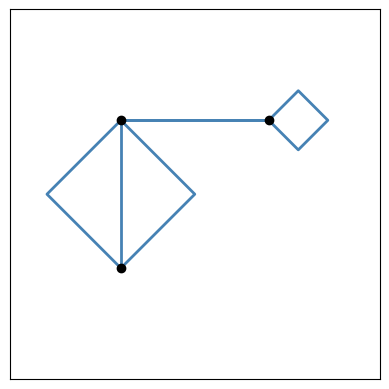

networkx.classes.multidigraph.MultiDiGraph

In [17]:
G = nx.MultiDiGraph()
G.add_node(0, x=0, y=0)
G.add_node(1, x=0, y=1)
G.add_node(2, x=1, y=1)
G.add_edge(1, 0, 2, geometry=shapely.LineString([[0, 1], [-0.5, 0.5], [0, 0]]))
G.add_edge(0, 1, 0, geometry=shapely.LineString([[0, 0], [0, 1]]))
G.add_edge(0, 1, 1, geometry=shapely.LineString([[0, 0], [0.5, 0.5], [0, 1]]))
G.add_edge(1, 2, geometry=shapely.LineString([[0, 1], [1, 1]]))
G.add_edge(2, 1, geometry=shapely.LineString([[1, 1], [0, 1]]))
G.add_edge(
    2,
    2,
    geometry=shapely.LineString([[1, 1], [1.2, 0.8], [1.4, 1], [1.2, 1.2], [1, 1]]),
)
for e in G.edges:
    G.edges[e]["length"] = G.edges[e]["geometry"].length
utgut.plot_graph(G, rel_buff=1.5)
type(G)

Since we are using the `osmnx.get_undirected` function, we need to first make our graph osmnx compatible, then we can transform it. The reason why we are using it is that otherwise if doing a simple `networkx.MultiGraph` on the graph, some edges might be lost. OSMnx ensure that all edges with a different geometry for a same pair of nodes are kept.

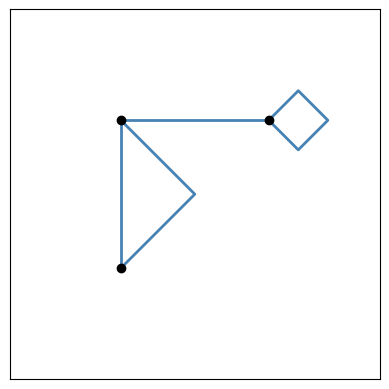

networkx.classes.multigraph.MultiGraph

In [18]:
H = nx.MultiGraph(G)
utgut.plot_graph(H, rel_buff=1.5)
type(H)

Using our function, we add one node for each parallel edges so two, and two nodes for the self-loop:

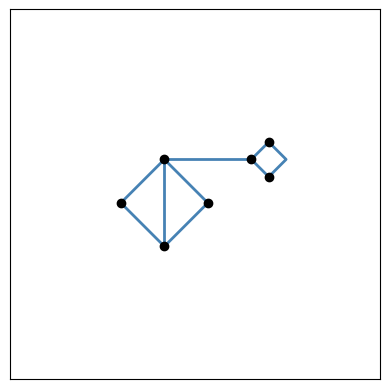

networkx.classes.graph.Graph

In [19]:
G = utgut.make_osmnx_compatible(G)
G = ordut.multidigraph_to_graph(G)
utgut.plot_graph(G, rel_buff=1.5)
type(G)

## Test disconnected component

A potential constraint in the order of construction is to keep the network connected.

In the subtractive order, the limit case is one where there are in the final graph (in the subtractive order the initial stage) less components than in the initial graph (in the final stage). This can happen if there are in the built network multiple components but not on the final bicycle network plan.

On the first figure built is on yellow, unbuilt is on black. On the second figure valid edges to remove are in green, invalid edges to remove are in red.

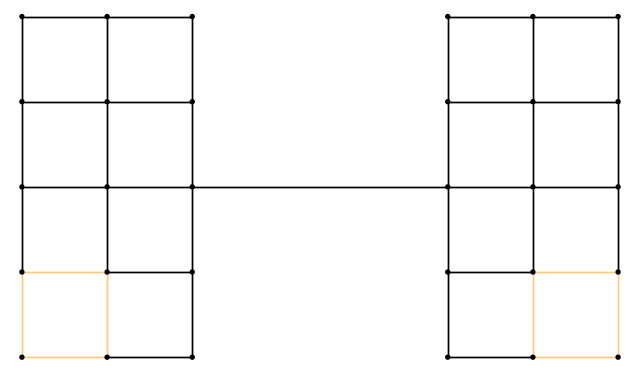

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
G = create_graph.create_bridge_graph(outrows=2, bridges=1)
# Create built component on both sides of the bridge
for edge in G.edges:
    G.edges[edge]["built"] = 0
G.edges[0, 1]["built"] = 1
G.edges[0, 5]["built"] = 1
G.edges[1, 6]["built"] = 1
G.edges[5, 6]["built"] = 1
G.edges[20, 21]["built"] = 1
G.edges[20, 25]["built"] = 1
G.edges[21, 26]["built"] = 1
G.edges[25, 26]["built"] = 1
# For visualization purpose using osmnx edge colors
G_plot = utgut.make_osmnx_compatible(G)
ec = ox.plot.get_edge_colors_by_attr(G_plot, "built", cmap="copper")
ox.plot_graph(G_plot, bgcolor="white", node_color="black", edge_color=ec)

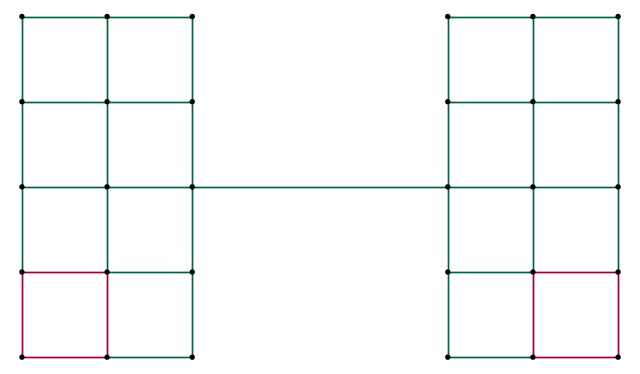

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [21]:
invalid_edges = growth.get_subtractive_invalid_edges(G, built=True)
for edge in G.edges:
    G.edges[edge]["valid"] = 1
for edge in invalid_edges:
    G.edges[edge]["valid"] = 0
# For visualization purpose using osmnx edge colors
G_plot = utgut.make_osmnx_compatible(G)
ec = ox.plot.get_edge_colors_by_attr(G_plot, "valid", cmap="RdYlGn")
ox.plot_graph(G_plot, bgcolor="white", node_color="black", edge_color=ec)

As we can see the bridge is also a valid edge to remove, as it would create two components where there is a built part.

In the additive order, the limit case is one where there are in the final graph more components than in the initial graph. This can be possible if the final bicycle network plan have multiple components, and no built part on all of them:

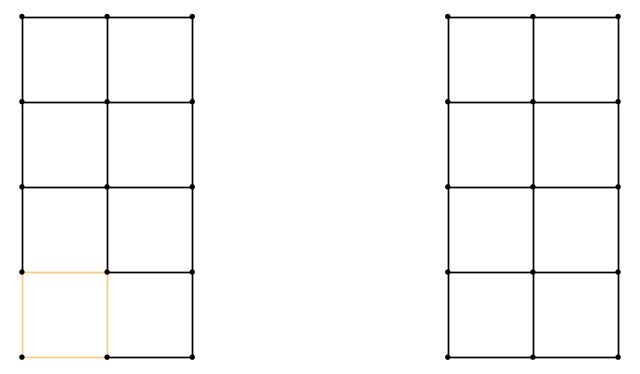

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [22]:
G = create_graph.create_bridge_graph(outrows=2, bridges=1)
# Remove the bridge to create two components
G.remove_edge(12, 17)
# Create built component on only one of the two components
for edge in G.edges:
    G.edges[edge]["built"] = 0
G.edges[0, 1]["built"] = 1
G.edges[0, 5]["built"] = 1
G.edges[1, 6]["built"] = 1
G.edges[5, 6]["built"] = 1
# For visualization purpose using osmnx edge colors
G_plot = utgut.make_osmnx_compatible(G)
ec = ox.plot.get_edge_colors_by_attr(G_plot, "built", cmap="copper")
ox.plot_graph(G_plot, bgcolor="white", node_color="black", edge_color=ec)

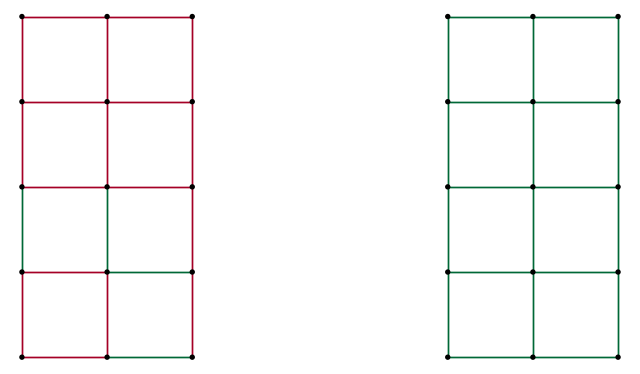

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
invalid_edges = growth.get_additive_invalid_edges(
    G.edge_subgraph([edge for edge in G.edges if G.edges[edge]["built"] == 1]), G
)
for edge in G.edges:
    G.edges[edge]["valid"] = 1
for edge in invalid_edges:
    G.edges[edge]["valid"] = 0
# For visualization purpose using osmnx edge colors
G_plot = utgut.make_osmnx_compatible(G)
ec = ox.plot.get_edge_colors_by_attr(G_plot, "valid", cmap="RdYlGn")
ox.plot_graph(G_plot, bgcolor="white", node_color="black", edge_color=ec)

As we can see on the component where there is the built part only edges connected to the built part are valid, while on the second component since it needs to be grown from scratch any edge is valid.

## Workflow for growth